# Classification problems with Neural Networks in PyTorch
    
<a rel="license" href="https://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**: 
- Dr Antonia Mey (antonia.mey@ed.ac.uk)
- Katerina Karoni

module --> package --> library --> framework

PyTorch is a Python framework that provides two high-level features:

    Tensor computation (like NumPy) with strong GPU acceleration
    Deep neural networks built on a autograd system

You can reuse your favorite Python packages such as NumPy to extend PyTorch when needed.

**<h2>Pytorch Installation**

To install the PyTorch binaries, you will need to use one of two supported package managers: Anaconda or pip. Anaconda is the recommended package manager as it will provide you all of the PyTorch dependencies in one, sandboxed install, including Python.

**Installing Anaconda** (Anaconda downloads the python interpreter/compiler as apart of the package)

https://docs.anaconda.com/anaconda/install/linux/

Installing torch

https://pytorch.org/get-started/locally/

**<h2>Pytorch Basics**

We will look at:
- Tensors
- Autograd
- Building a dataset
- Building a neural network
- Choosing optimiser
- Training and testing the model


Once we have installed pytorch, we can import the package like this

In [1]:
import torch

**<h2>Tensors**
    
A PyTorch Tensor is basically the same as a numpy array: it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array to be used for arbitrary numeric computation.

The biggest difference between a numpy array and a PyTorch Tensor is that a PyTorch Tensor can run on either CPU or GPU. To run operations on the GPU, just cast the Tensor to a cuda datatype.

In [2]:
x = torch.Tensor([[1,2,3],[4,5,6]])
print('x =',x, '\n')

print('Size of x = ', x.size(), '\n') # np.shape(x) also works

print('Data type of x = ', x.dtype)

x = tensor([[1., 2., 3.],
        [4., 5., 6.]]) 

Size of x =  torch.Size([2, 3]) 

Data type of x =  torch.float32


In [3]:
# we can also specify data type

y = torch.zeros(2,3,dtype=torch.float32) 

print('y =' , y, '\n')

print('Data type of y = ', y.dtype)

y = tensor([[0., 0., 0.],
        [0., 0., 0.]]) 

Data type of y =  torch.float32


**Casting tensor x as cuda datatype if cuda available**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Attention: ```x.to(device)``` will not cast ```x```as cuda datatype - we need
```x = x.to(device)```

In [5]:
y = x.to(device) # or x = x.cuda() for GPU
print(x.is_cuda)

False


Note: For tensors ```x.to(device)```, as mentioned does not move ```x``` to cuda and we need to write ```x = x.to(device)``` instead.

However, for neural networks, ```net.to(device)``` and
```net = net.to(device)``` are equivalent.


**Tensor Data types**

```DoubleTensor``` is ```64-bit``` floating point and ```FloatTensor``` is ```32-bit``` floating point tensor. So a ```FloatTensor``` uses half of the memory as a same tensor-size ```DoubleTensor``` uses. Also GPU and CPU computations with lower precision are much faster.  However, if high precision is needed, go for ```DoubleTensor``` . So Pytorch leaves it to user to choose which one to use.

Set default tensor type for your notebook

In [6]:
torch.set_default_tensor_type('torch.FloatTensor')    # 32 bits
#or
torch.set_default_tensor_type('torch.DoubleTensor')    # 64 bits

In [7]:
x = torch.zeros(2,3) 
print(x)
print(x.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.float64


**<h2> Autograd**
    
    https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

```torch.autograd``` is the automatic differentiation package in pytorch - it is PyTorch’s automatic differentiation engine that powers neural network training.  Using autograd on a tensor, requires minimal changes to our code - we just need to add the keyword ```requires_grad=True```. For example

In [8]:
a = torch.tensor([1., 5.],requires_grad=True) # float tensor
b = torch.tensor([3., 6.],requires_grad=True) # tensor needs to be floating point to 
                                              # set requires_grad = True

*Note*: ```torch.tensor``` is different to ```torch.Tensor``` - the former infers the dtype automatically from the input, e.g. ```[1., 5.]``` vs ```[1,5]```, while ```torch.Tensor``` returns a ```torch.FloatTensor``` (32-bit by default, otherwise whatever length we have set as default).

$$Q = 3a^3 - b^2$$


**Forward pass**

In [9]:
Q = 3*a**3 - b**2
Q.is_leaf

False

In [10]:
print('Q=',Q)

Q= tensor([ -6., 339.], grad_fn=<SubBackward0>)


$$\frac{\partial Q}{\partial a} = 9 a^2$$
$$\frac{\partial Q}{\partial b} = -2b$$

```Q``` will be also be tracked by autograd as it was created by operations on variables with ```requires_grad = True```

In [11]:
Q.requires_grad

True

In [12]:
a.is_leaf

True

When a tensor is first created, it becomes a leaf node.

Basically, all inputs and weights of a neural network are leaf nodes of the computational graph.

When any operation is performed on a tensor, it is not a leaf node anymore.

Only leaf Tensors will have their grad populated during a call to backward().
https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html

In [13]:
l=torch.Tensor([1,2])

In [14]:
Q.is_leaf

False

<!-- $$\frac{\partial Q}{\partial a} = \frac{dQ}{dQ}  \frac{\partial Q}{\partial a}$$ -->

When we call the method ```backward()``` on ```Q```, autograd calculates these gradients and stores them in the respective tensors’ ```.grad``` attribute.

**Backward pass**

In [15]:
dQ_dQ = torch.tensor([1.,1.])

In [16]:
Q.backward(gradient=dQ_dQ)

In [17]:
print(a.grad)
print(b.grad)

tensor([  9., 225.])
tensor([ -6., -12.])


In [18]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


**<h2>MNIST handwritten digit classification using neural networks**

We will now present an example where we train a fully-connected neural network on a popular benchmark dataset: MNIST handwritten digits.

The MNIST hadwritten digits dataset consists of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 image and an associated label from one of 10 classes.

**<h3> Importing relevant packages**

In [19]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from   torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

**<h3>Load dataset**

The ```torchvision``` library consists of popular datasets, model architectures, and common image transformations for computer vision.

In [20]:
mnist_train  = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test   = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

We should now have a folder ```./data``` with the ```MNIST``` dataset in it

In [21]:
!ls

 AI4SD_ML_Summer_School   MAC_MIGS		 t10k-images-idx3-ubyte.gz
 continualai		  MATLAB		 t10k-labels-idx1-ubyte.gz
 data			  Mech.ntua		 train-images-idx3-ubyte.gz
 Deutsch		  ML_MD_software	 train-labels-idx1-ubyte.gz
 diabetes.csv		  mnist.pkl		 various
'docs&certificates'	  Photos_Kat
 GitHub			  pytorch_basics.ipynb


In [22]:
print(type(mnist_train))
print(len(mnist_train))
print(len(mnist_test))

print(type(mnist_train[0]))
print(len(mnist_train[0]))

<class 'torchvision.datasets.mnist.MNIST'>
60000
10000
<class 'tuple'>
2


```mnist_train[0])``` is a tuple, whose first element is the image tensor representation and the second element is the label of the image (0 to 9)

Let's see what the first image in our training set looks like

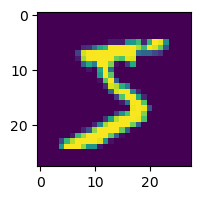

In [23]:
plt.rcParams["figure.figsize"] = (2,2)                # set figure size
plt.imshow(mnist_train[0][0].view(28,28))             # show image

**<h3> Dataloader class**
    
https://pytorch.org/docs/stable/data.html#map-style-datasets

At the heart of ```PyTorch``` data loading utility is the ```torch.utils.data.DataLoader``` class. It represents a Python iterable over a dataset

```python
DataLoader(dataset, batch_size=1, shuffle=False, 
           sampler=None,batch_sampler=None, num_workers=0,
           collate_fn=None,pin_memory=False, drop_last=False, 
           timeout=0, worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)
```

The most important argument of ```DataLoader``` constructor is ```dataset```, which indicates a dataset object to load data from. PyTorch supports two different types of datasets:

- Map style datasets: Datasets that implement the ```__getitem__()``` and ```__len__()``` methods and are maps from keys to data samples.

- Iterable style datasets: When reading from a stream of data. 


In [24]:
# dir(mnist_train)
# mnist_train.__getitem__(0)

In [25]:
dataloader_train  =  DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)
dataloader_test   =  DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True)

In [26]:
# Reshape train and test images from 28x28 to 1x784
for i,data in enumerate(dataloader_train):
    xtrain      = data[0].view(-1,784)       # torch.Tensor.view() is equivalent to reshape
    ytrain      = data[1]                    # train labels

for i,data in enumerate(dataloader_test):      
    xtest        = data[0].view(-1,784)     # test images, The size -1 is inferred from other dimensions
    xtest_conv   = data[0]                  # we ll use these non-flattened images for testing the convolutional net
    ytest=data[1]                           # test labels

In [27]:
flat_mnist_train       = TensorDataset(xtrain, ytrain)
flat_dataloader_train  =  DataLoader(flat_mnist_train, batch_size=256, shuffle=True)

In [28]:
np.shape(xtrain)

torch.Size([60000, 784])

**<h3>Defining the model**

In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
class Neural_net(nn.Module):    # this class inherits from nn.Module
    def __init__(self):
        super(Neural_net, self).__init__() #this calls the constructor of the parent class nn.Module
        
        # define network layers
        self.fc1 = nn.Linear(784, 400)   # nn.Linear is a class for linear layers (16,12) are the constructor arguments
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 400)
        self.fc4 = nn.Linear(400, 10)
        torch.manual_seed(4)           # generating numbers changes the state of the random number generator.
                                       # we thus have to set the seed back to 2  
#         self.initialize_weights()
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))  # https://discuss.pytorch.org/t/what-is-the-difference-between-torch-relu-torch-nn-relu-and-torch-nn-functional-relu/91101/2
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
#     def initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m,nn.Linear):
#                 nn.init.kaiming_normal_(m.weight)
#                 nn.init.constant_(m.bias,0.0)
    
# nn.ReLU() creates an nn.Module which you can add e.g. to an nn.Sequential model.
# nn.functional.relu on the other side is just the functional API call to the relu function, so that you can add 
# it e.g. in your forward method yourself.

# Generally speaking it might depend on your coding style if you prefer modules for the activations or the 
# functional calls. Personally I prefer the module approach if the activation has an internal state, e.g. PReLU.
        

In [31]:
net = Neural_net()

In [32]:
def class_accuracy(output,y):
    '''If np.argmax(out,axis=1)-y is non-zero, i.e. label y is 9 and prediction is 5 then 
       diff is incremented by 1, i.e. every time there is a mismatch between prediction and label.
       The ratio diff/np.size(y) gives us the ratio of false predictions over the total number of datapoints.
       One minus that gives the model accuracy.
       '''
    # we can't call numpy() on Tensors that requires grad. So, in order to compute diff (see below)
    # we need to use tensor.detach().numpy()
    output = output.cpu().detach().numpy()    # no need for the .cpu() here as we are working with cpu tensors
    y      = y.cpu().detach().numpy()
    diff   = np.count_nonzero(np.argmax(output,axis=1)-y) # np.argmax returns the index/indices of max value(s)
                                                        # along specified axis
    return (1-(diff/np.size(y)))*100

**<h3> Model Training**

In [33]:
import torch.optim as optim

Cross entropy loss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss):

$$H(p,q) =  –\sum_{x \in \mathcal{X}} p(x)  \log(q(x))$$

For binary classification

$$loss=−(y \log(p)+(1−y) \log(1−p))$$

So, if ```y=1``` and ```p=1``` then $loss = - 1 \log(1) = 0$

and if ```y=1``` and ```p=0``` then $loss = -1 \log(0)=+ \infty$

Similarly, if ```y=0``` and ```p=0``` then $loss = - (1-0) \log(1-0) = 0$

and if ```y=0``` and ```p=1``` then $loss = - (1-0) \log(1-1) = +\infty$

In [34]:
net

Neural_net(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=10, bias=True)
)

In [35]:
for p in net.parameters():
    print(p.grad)

None
None
None
None
None
None
None
None


In [45]:
# for n,p in net.named_parameters():
#     print(n)
#     print(p.grad)

In [36]:
num_epochs = 5

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=5*10**-3, momentum=0.9)

for epoch in range(num_epochs): 
    for i,data in enumerate(flat_dataloader_train):
        # Load in the training datapoints
        x=data[0]                  # equivalent to torch.float64
        y=data[1]   
        optimizer.zero_grad()
        output = net(x)
        loss = criterion(output,y) 
        loss.backward()
        optimizer.step()
                   
        if epoch % 1 == 0 and i==0:
            # evety 100 epochs after the first batch 
            acc        = class_accuracy(output,y)
            outputtest = net(xtest)
            loss_test  = criterion(outputtest,ytest)
            acc_test   = class_accuracy(outputtest,ytest)
            print(f'epoch {epoch}/{num_epochs}, accuracy train {acc:.2f} %, loss train, {loss.item():.5f}, accuracy test {acc_test:.2f} %, loss test, {loss_test.item():.5f}')

epoch 0/1, accuracy train 9.38 %, loss train, 2.30534, accuracy test 9.81 %, loss test, 2.30254


**<h3>Alternative model: Convolutional neural network**

In [37]:
dataloader_train  =  DataLoader(mnist_train, batch_size=256, shuffle=True)
dataloader_test   =  DataLoader(mnist_test, batch_size=256, shuffle=True)

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()              # Randomly zero out entire channels of the input tenor
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x



In [39]:
num_epochs = 5

criterion = nn.CrossEntropyLoss()

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(num_epochs): 
    for i,data in enumerate(dataloader_train):
        # Load in the training datapoints
        x=data[0]                  # equivalent to torch.float64
        y=data[1].long()   
        optimizer.zero_grad()
        output = model(x.double())
        loss = criterion(output,y) 
        loss.backward()
        optimizer.step()
                   
        if (epoch) % 1 == 0 and i==0:
            # evety 100 epochs after the first batch 
            acc        = class_accuracy(output,y)
            outputtest = model(xtest_conv)
            loss_test  = criterion(outputtest,ytest)
            acc_test   = class_accuracy(outputtest,ytest)
            print(f'epoch {epoch}/{num_epochs}, accuracy train {acc:.2f} %, lost train, {loss.item():.5f}, accuracy test {acc_test:.2f} %, lost test, {loss_test.item():.5f}')

epoch 0/5, accuracy train 13.67 %, lost train, 2.29797, accuracy test 12.38 %, lost test, 2.30212
epoch 1/5, accuracy train 82.03 %, lost train, 0.53316, accuracy test 81.83 %, lost test, 0.58233
epoch 2/5, accuracy train 83.20 %, lost train, 0.58118, accuracy test 87.35 %, lost test, 0.41130
epoch 3/5, accuracy train 89.06 %, lost train, 0.32455, accuracy test 90.40 %, lost test, 0.32772
epoch 4/5, accuracy train 90.23 %, lost train, 0.27760, accuracy test 91.45 %, lost test, 0.28107


**<h3> Pima Indians diabetes dataset**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases (United States). The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

We will use ```pandas``` to load the dataset. Pandas is an open source Python package that is most widely used for data science/data analysis and machine learning tasks. It is built on top of the ```numpy``` package.

In [40]:
# conda install -c anaconda pandas

In [41]:
import pandas as pd

In [42]:
df = pd.read_csv('./diabetes.csv', delimiter=',')

In [43]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


https://www.kaggle.com/code/aadhilimam/pima-diabetes-classification-using-pytorch